In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.release_transitions import ReleasedTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml

In [2]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/VA/VA_parole_model_inputs.yaml')
test_sim.simulate_baseline(['parole'])

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 1024 results
transitions_data returned 7886 results
total_population_data returned 0 results


ValueError: Only 'middle' projection_type is supported for constant admissions

In [ ]:
# Policy Options
# manditory_minimum_reduction = incarceration_transitions.IncarceratedTransitions.apply_mandatory_minimum_reduction
# reduce_manditory_minimum_5y = partial(manditory_minimum_reduction, sentence_reduction_years=5)
# abolish_manditory_minimum = partial(manditory_minimum_reduction, sentence_reduction_years=None)

#taken from https://vadoc.virginia.gov/media/1472/vadoc-research-state-responsible-demographic-report-2019.pdf
level_breakdown = {1: 0.24, 2: 0.59, 3: 0.11, 4: 0.06}

from spark.sentencing_policy_impact_v1.historical_data import mandatory_minimums

def apply_earned_sentence_credits(mandatory_minimum):
    return partial(
        IncarceratedTransitions.apply_earned_time_sentence_reduction,
        level_breakdown=level_breakdown,
        mandatory_minimum=mandatory_minimum
    )

In [ ]:
# Policy Option Methods
def replace_sentence_distribution_with_other_offense(df, offense_codes):
    offense_data = df[df['offense_code'].isin(offense_codes)]
    return partial(IncarceratedTransitions.use_alternate_sentence_data, 
                   alternate_historical_admissions=offense_data, retroactive=True)

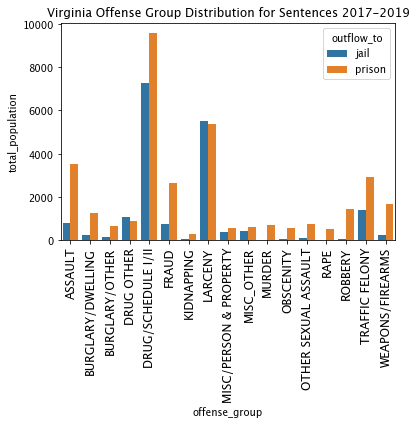

In [6]:
# # Offense Group Options
# overall_admissions = jail_prison_admissions.groupby(['offense_group', 'outflow_to'], as_index=False).agg({'total_population': 'sum'})
# offense_group_chart = sns.barplot(data=overall_admissions, x='offense_group', y='total_population', hue='outflow_to')
# offense_group_chart.set_title('Virginia Offense Group Distribution for Sentences 2017-2019')
# chart_axis_label = offense_group_chart.set_xticklabels(offense_group_chart.get_xticklabels(), rotation=90, 
#                                                        fontsize='large')

In [7]:
# #crimes currently in the mandatory minimums dict and modeled
# all_crimes = jail_prison_admissions.groupby('offense_code').sum()
# print(len(all_crimes))
# print(len(all_crimes[all_crimes['total_population'] > 150]))

# print(sum(all_crimes['total_population']))
# print(sum(all_crimes[all_crimes['total_population'] > 150]['total_population']))

# modeled_crimes = all_crimes[all_crimes['total_population'] > 150].index.unique()
# modeled_crimes_data = jail_prison_admissions[jail_prison_admissions['offense_code'].isin(modeled_crimes)]

# from spark.sentencing_policy_impact_v1.historical_data import mandatory_minimums, VA_validation_data

# for crime in modeled_crimes:
#     if crime not in mandatory_minimums:
#         mandatory_minimums[crime] = 1


247
60
52291
46459


In [8]:
# #just drug crimes - run this OR the above
# #crimes currently in the mandatory minimums dict and modeled
# drug_crimes = jail_prison_admissions[jail_prison_admissions['offense_group'] == 'DRUG/SCHEDULE I/II']
# all_crimes = drug_crimes.groupby('offense_code').sum()
# print(len(all_crimes))
# print(len(all_crimes[all_crimes['total_population'] > 150]))

# print(sum(all_crimes['total_population']))
# print(sum(all_crimes[all_crimes['total_population'] > 150]['total_population']))

# modeled_crimes = all_crimes[all_crimes['total_population'] > 150].index.unique()
# modeled_crimes_data = jail_prison_admissions[jail_prison_admissions['offense_code'].isin(modeled_crimes)]

# from spark.sentencing_policy_impact_v1.historical_data import mandatory_minimums

# for crime in modeled_crimes:
#     if crime not in mandatory_minimums:
#         mandatory_minimums[crime] = 1


13
9
16844
16701


In [10]:
# Policy Selections per offense group
disaggregation_axes = ['offense_code']

#both
policy_df = []
for crime in modeled_crimes:
#     policy_df = policy_df.append({
#         'sub_population': {disaggregation_axes[0]: crime},
#         'compartment': 'prison',
#         'non_retroactive_policies': [apply_earned_sentence_credits(mandatory_minimums[crime])]
#     }, ignore_index=True)
    policy_df.append(SparkPolicy(policy_fn=apply_earned_sentence_credits(mandatory_minimums[crime]),
                                 spark_compartment='prison',
                                 sub_population={disaggregation_axes[0]: crime},
                                 apply_retroactive=False
                                ))
    
for offense_code in ['NAR3038', 'NAR3087']:
    policy_df.append(SparkPolicy(
        policy_fn=replace_sentence_distribution_with_other_offense(jail_prison_admissions, ['NAR3043']),
        spark_compartment='prison',
        sub_population={disaggregation_axes[0]: offense_code},
        apply_retroactive=True
    ))

# policy_df[(policy_df['sub_population'] == {disaggregation_axes[0]: 'NAR3038'}) 
#           & (policy_df['compartment'] == 'prison')]['retroactive_policies'] = \
#     [replace_sentence_distribution_with_other_offense(jail_prison_admissions, ['NAR3043'])]

# policy_df[(policy_df['sub_population'] == {disaggregation_axes[0]: 'NAR3087'}) 
#           & (policy_df['compartment'] == 'prison')]['retroactive_policies'] = \
#     [replace_sentence_distribution_with_other_offense(jail_prison_admissions, ['NAR3043'])]



# #mm
# policy_df = pd.DataFrame(columns=['sub_population', 'compartment', 'retroactive_policies', 'non_retroactive_policies'])
# policy_df = policy_df.append({
#     'sub_population': {disaggregation_axes[0]: 'NAR3038'},
#     'compartment': 'prison',
#     'retroactive_policies': [replace_sentence_distribution_with_other_offense(jail_prison_admissions, ['NAR3043'])],
# }
# policy_df = policy_df.append({
#     'sub_population': {disaggregation_axes[0]: 'NAR3087'},
#     'compartment': 'prison',
#     'retroactive_policies': [replace_sentence_distribution_with_other_offense(jail_prison_admissions, ['NAR3043'])],
# }

# #earned sentence credits
# policy_df = pd.DataFrame(columns=['sub_population', 'compartment', 'retroactive_policies', 'non_retroactive_policies'])
# for crime in modeled_crimes:
#     policy_df = policy_df.append({
#         'sub_population': {disaggregation_axes[0]: crime},
#         'compartment': 'prison',
#         'non_retroactive_policies': [apply_earned_sentence_credits(mandatory_minimums[crime])]
#     }, ignore_index=True)

policy_df
    

In [16]:
# def compute_mean_prison_sentence_length(jail_prison_sentences, offense_codes):
#     prison_offense_sentences = jail_prison_sentences[(jail_prison_sentences['inflow_to'] == 'prison')
#                                                      & (jail_prison_sentences['offense_code'].isin(offense_codes))]
#     total_sentences = sum(prison_offense_sentences['total_population'])
#     total_sentence_length_sum = sum(prison_offense_sentences['compartment_duration'] * prison_offense_sentences['total_population'])
#     return total_sentence_length_sum/total_sentences

In [17]:
# # 1st offense intent to sell avg prison sentence length
# compute_mean_prison_sentence_length(jail_prison_sentences, ['NAR3043'])

2.5800371757145015

In [18]:
# # Felon weapons offenses avg prison sentence length
# compute_mean_prison_sentence_length(jail_prison_sentences, ['WPN5291', 'WPN5298'])

1.282568486059302

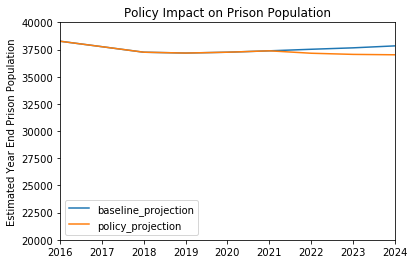

In [20]:
# from spark.sentencing_policy_impact_v1.historical_data import total_state_responsible_adult_population
# prison_results = projection_results[projection_results['compartment'] == 'prison']
# prison_population_differential = prison_results['policy_total_population'] - prison_results[
#     'control_total_population']
# prison_population_differential.index = prison_results['year']
# population_differential = prison_population_differential[prison_population_differential.index.isin(total_state_responsible_adult_population.index)]
# projection_results = pd.DataFrame({
#     'baseline_projection': total_state_responsible_adult_population, 
#     'policy_projection': total_state_responsible_adult_population + population_differential
# })
# projection_results.plot(y=['baseline_projection', 'policy_projection'], ylim=[20000, 40000], xlim = [2016, None])
# plt.title("Policy Impact on Prison Population")
# plt.ylabel("Estimated Year End Prison Population")
# plt.legend(loc='lower left')
